In [1]:
from data_processing_helper import * 
import warnings
warnings.filterwarnings('ignore')

# Import time-frequency functions
from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time
from neurodsp.plts.time_series import plot_time_series, plot_instantaneous_measure


In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

from sklearn.metrics import accuracy_score

## Specific helper functions

In [3]:
def getOutputLabelsAndEpochTimes(event_df):
    # Generates the ordered list of output labels and epoch time pairs
    # Input: event_df -- the event dataframe from the csv file
    # Output: 
    #    output_labels -- [1, 2, 4, 3, etc] where the integers correspond to the trial type encoded
    #    epoch_times -- [[<timestamp of start>, <timestamp of end>], [<timestamp of start>, <timestamp of end>], etc]
    
    output_labels = []
    epoch_times = []
    current_epoch = []
    for index, row in event_df.iterrows():
        event_info = row['EventStart'].split("_")
        if event_info[0] == 'start': 
            output_labels.append(int(event_info[1]))
            current_epoch.append(row['time'])
        else :
            current_epoch.append(row['time'])
            epoch_times.append(list(current_epoch))
            current_epoch = []
    return np.array(output_labels), np.array(epoch_times)

In [4]:
def getEEGEpochs(epoch_times, eeg_df, target_num_trials=1000):
    # Slices and generates the epochs in the eeg_df given the epoch_times
    # Input: 
    #    epoch_times: [[<timestamp of start>, <timestamp of end>], [<timestamp of start>, <timestamp of end>], etc]
    #    eeg_df: dataframe from csv file
    # Output: 
    #    a numpy array containing eeg_epochs (#epoch, #chans, #timepoints)
    eeg_epochs = []
    for epoch_time in epoch_times: 
        baseline_df = eeg_df[(eeg_df['time'] > (epoch_time[0] - 1.5)) & (eeg_df['time'] < ((epoch_time[0])))]
        baseline_df = baseline_df.drop(columns=['time'])
        baselines = np.mean(baseline_df[eeg_chans].values, 0)
        sub_df = eeg_df[(eeg_df['time'] > epoch_time[0]) & (eeg_df['time'] < epoch_time[1])]
        sub_df = sub_df.drop(columns=['time'])
        sub_df = sub_df - baselines
        num_above = len(sub_df) - target_num_trials
        if num_above >= 0:
            epoch = np.array(sub_df.values[num_above // 2: len(sub_df) - num_above // 2])[:1000]
            eeg_epochs.append(epoch.T)
            if len(epoch) != 1000:
                print("Warning: Potential off by 1 error. Found trail with != 1000 samples:", len(epoch))
        else: 
            print("Warning: Epoch with less than", target_num_trials, "eeg samples")
    return np.array(eeg_epochs)


In [5]:
import pyeeg
def getPowerRatio(eeg_data, binning, eeg_fs=250):
    power, power_ratio = pyeeg.bin_power(eeg_data, binning, eeg_fs)
    return np.array(power)
def getIntervals(binning): 
    intervals = list()
    for i, val in enumerate(binning[:-1]): 
        intervals.append((val, binning[i+1]))
    return intervals

In [6]:
# Abstract class
class myModel:
    def __init__(self):
        pass
    def fit(X, Y):
        pass
    def predict(X):
        pass
    def evaluate(X, Y): 
        pass

## Load Data

In [7]:
## Loading data without EMG
eeg_filename = "./data/self_recorded/eeg_data 15_motorvis.csv"
event_filename = "./data/self_recorded/event_data 15_motorvis.csv"

eeg_chans = ['C4','C2', 'C1', 'C3']
chans = eeg_chans
eeg_df = pd.read_csv(eeg_filename)
eeg_df.columns=['time','C4', 'C2', 'C1', 'C3']

event_df = pd.read_csv(event_filename)
event_df.columns=['time', 'EventStart']
event_types = {0:"eye_close", 1:"left", 2:"right", 3:"foot", 4:"idle"}

# Filter the full data
filtered_df = eeg_df.copy()
for chan in chans:
    filtered_df[chan] = filterEEG(filtered_df[chan].values)

In [8]:
# ## Loading data with EMG
# eeg_filename = "./data/self_recorded/eeg_data 15_withEMG.csv"
# event_filename = "./data/self_recorded/event_data 15_withEMG.csv"

# eeg_chans = ['C4','C2', 'C1', 'C3']
# chans = ['EMG_R', 'EMG_L', 'VEOG'] + eeg_chans
# eeg_df = pd.read_csv(eeg_filename)
# eeg_df.columns=['time'] + chans

# event_df = pd.read_csv(event_filename)
# event_df.columns=['time', 'EventStart']
# event_types = {0:"eye_close", 1:"left", 2:"right", 3:"foot", 4:"idle"}

# # Filter the full data
# filtered_df = eeg_df.copy()
# for chan in chans:
#     filtered_df[chan] = filterEEG(filtered_df[chan].values)

In [9]:
filtered_df.head(2)

,time,C4,C2,C1,C3
0,1.602196e+09,-451.295598,-689.560321,-266.691192,-1062.534000
1,1.602196e+09,21110.796004,19952.002466,25496.237674,25480.294684


In [10]:
event_df.head(2)

,time,EventStart
0,1.602196e+09,start_0
1,1.602196e+09,end_0


In [11]:
# Process dfs to get labels, raw eeg epochs, epochs of filtered eeg data, filtered epoch data
output_labels, epoch_times = getOutputLabelsAndEpochTimes(event_df)
raw_eeg_epochs = getEEGEpochs(epoch_times, eeg_df) # Raw eeg epochs
filtered_epochs = getEEGEpochs(epoch_times, filtered_df) # Epoched after filtering
epoch_then_filter_epochs = getFilteredEpochs(raw_eeg_epochs) # Filtered after epoching


# Create DataFrames
raw_eeg_epoch_df = getDF(raw_eeg_epochs, output_labels, epoch_times, chans)
filtered_epoch_df = getDF(filtered_epochs, output_labels, epoch_times, chans)
filtered_epoch_df.head(20)

epoch_then_filter_df = getDF(epoch_then_filter_epochs, output_labels, epoch_times, chans)


# Power Bin Modeling

In [12]:
# Extract trials that are for left vs right hand imagery
df_to_use = filtered_epoch_df
filtered_epoch_bi_class_df = df_to_use[(df_to_use['event_type'] == 1) | (df_to_use['event_type'] == 2)]
X = filtered_epoch_bi_class_df[eeg_chans].values
Y = filtered_epoch_bi_class_df['event_type'].values

# Split the 4s trials into 2.8s trials. front and end to obtain 2x trials
X_split = []
Y_split = []
for i in range(len(Y)): 
    eeg_data = []
    for j in range(4): 
        eeg_data.append(X[i, j][:]) # Epoch then filter creates large shifts in voltage near the ends. 
    X_split.append(np.array(eeg_data))
    Y_split.append(Y[i])

#     eeg_data_2 = []
#     for j in range(4): 
#         eeg_data_2.append(X[i, j][200:])
#     X_split.append(np.array(eeg_data_2))
#     Y_split.append(Y[i])

# Shuffle
X = np.array(X_split)
Y = np.array(Y_split)
temp=list(zip(Y, X))
random.shuffle(temp)
Y_shuffled, X_shuffled = zip(*temp)

# Split train/test
num_train = int(len(X_shuffled)*0.7)
X_train = np.array(X_shuffled[:num_train])
X_test = np.array(X_shuffled[num_train:])
Y_train = np.array(Y_shuffled[:num_train])
Y_test = np.array(Y_shuffled[num_train:])
X = np.array(X_shuffled)
Y = np.array(Y_shuffled)

In [13]:
# Power Bin Model (may have other decision algorithms)
class PowerBinModel(myModel): # XDAWN Covariance Preprocessing + Linear Regression Classifier
    def __init__(self, chans, num_top=5):
        super().__init__()
        self.mod_types = [LogisticRegression, LinearDiscriminantAnalysis]
        self.mod_type = self.mod_types[0] 
        self.binning = [1, 4, 7, 12, 30] # [1, 3, 5, 7, 9, 12, 20, 40] #
        self.intervals = getIntervals(self.binning)
        self.model = self.mod_type()
        self.scaler = StandardScaler()
        self.chans = chans
        self.feat_names = [str(ch) + "_" + str(ints) for ch in self.chans for ints in self.intervals]
        self.feat_names.extend([str(ch) + "_mobility" for ch in self.chans])
        self.feat_names.extend([str(ch) + "_complexity" for ch in self.chans])
        self.feat_names.extend(['left_'+ str(interval) for interval in self.intervals])
        self.feat_names.extend(['right_'+ str(interval) for interval in self.intervals])
        self.feat_names.extend(['left_minus_right_'+ str(interval) for interval in self.intervals])

        self.feature_indx = None
        self.num_top = num_top
        
    def getFeatureNames(self):
        return self.feat_names
        
    def _getFeatures(self, eeg_datas) :
        feats = []
        mobs = []
        comps = []
        left_powers = {}
        right_powers = {}
        for i, eeg_data in enumerate(eeg_datas): 
            ratios = getPowerRatio(eeg_data, self.binning)
            
            feats.extend(ratios)

            mob, comp = pyeeg.hjorth(eeg_data)
            mobs.append(mob)
            comps.append(comp)
            ch = self.chans[i]
            for i, interval in enumerate(self.intervals) : 
                if (interval not in left_powers) or (interval not in right_powers): 
                    left_powers[interval] = 0
                    right_powers[interval] = 0
                if int(ch[1]) % 2 == 0: 
                    right_powers[interval] += ratios[i]
                else : 
                    left_powers[interval] += ratios[i]
        feats.extend(mobs)
        feats.extend(comps)
        left_powers_list = [] 
        right_powers_list = []
        for i, interval in enumerate(self.intervals) : 
            left_powers_list.append(left_powers[interval])
            right_powers_list.append(right_powers[interval])
        feats.extend(left_powers_list)
        feats.extend(right_powers_list)
        feats.extend(np.array(left_powers_list) - np.array(right_powers_list))
        
        return feats
    
    def _selectTopFeatures(self, X_features, Y) :
        # Get the unique classes of Y to be able to separate the features 
        unique_Y = np.unique(Y)
        X_features_mean = []
        X_features_std = []
        for un in unique_Y: 
            X_features_mean.append(np.mean(X_features[Y == un, :], 0))
            X_features_std.append(np.std(X_features[Y == un, :], 0) / np.sqrt(len(X_features[Y == un])))
        X_features_std_sum = np.sum(X_features_std, 0)
        X_features_mean_diff = np.abs(X_features_mean[0] - X_features_mean[1])
        X_features_mean_diff = X_features_mean_diff - X_features_std_sum
        
        # Get the index of the sorted mean difference array
        args = np.argsort(X_features_mean_diff)
        # Reverse args to largest features are first
        args = args[::-1]
        feature_indx = args[:self.num_top]
        X_features = np.transpose([X_features[:, i] for i in feature_indx])
        return X_features, feature_indx

    def fit(self, X, Y):
        # X shape must be (#Trials, #Chans, #Timepoints)
        
        # Check which model is the best 
        max_accs, best_model_idx = self.evaluate(X, Y)
        print("max accuracy:", max_accs)
        print("best model index:", best_model_idx)
        self.mod_type = self.mod_types[best_model_idx]
        self.model = self.mod_type()
        
        X_features = np.array([self._getFeatures(eeg_datas) for eeg_datas in X])
        X_features = self.scaler.fit_transform(X_features)
        X_features, self.feature_indx = self._selectTopFeatures(X_features, Y)
        
        self.model.fit(X_features,Y)
    
    def evaluate(self, X, Y): 
        unique_Y = np.unique(Y)
        loo = LeaveOneOut()
        X_features = np.array([self._getFeatures(eeg_datas) for eeg_datas in X])
        accs = [] 
        for mod in self.mod_types: 
            y_pred = []
            y_true = []
            for train_ix, test_ix in loo.split(Y):
                # split data
                X_train_i, X_test_i = X_features[train_ix, :], X_features[test_ix, :]
                y_train_i, y_test_i = Y[train_ix], Y[test_ix]

                scaler = StandardScaler()
                X_train_i = scaler.fit_transform(X_train_i)
                X_train_i, feature_indx = self._selectTopFeatures(X_train_i, y_train_i)


                # fit model
                model = mod()
                model.fit(X_train_i, y_train_i)

                X_test_i = scaler.transform(X_test_i)
                X_test_i = np.transpose([X_test_i[:, i] for i in feature_indx])
                

                # evaluate model
                yhat = model.predict(X_test_i)
                # store
                y_true.append(y_test_i[0])
                y_pred.append(yhat[0])

            # calculate accuracy
            acc = accuracy_score(y_true, y_pred)
            accs.append(acc)
        #print(accs)
        return max(accs), accs.index(max(accs))
        
    def predict(self, X):
        # X shape must be (#Trials, #Chans, #Timepoints)
        X_features = np.array([self._getFeatures(eeg_datas) for eeg_datas in X])
        X_features = self.scaler.transform(X_features)
        X_features = np.transpose([X_features[:, i] for i in self.feature_indx])
        
        return self.model.predict(X_features)


In [14]:
# Accuracy on the shuffled train and test split
num_feats_used = 11
power_bin_model = PowerBinModel(eeg_chans, num_top=num_feats_used)

power_bin_model.fit(X_train, Y_train)
all_feats = power_bin_model.getFeatureNames()
num_feats = len(all_feats)
print("num total feats", num_feats)
print("num used", num_feats_used)
for i in power_bin_model.feature_indx: 
    print(all_feats[i])

Y_pred = power_bin_model.predict(X_test)
print(classification_report(Y_test, Y_pred))
print("Accuracy:", sum(Y_test==Y_pred) / len(Y_test))

max accuracy: 0.8095238095238095
best model index: 1
num total feats 36
num used 11
C4_(12, 30)
left_minus_right_(4, 7)
right_(12, 30)
C2_(1, 4)
C2_(12, 30)
C3_(4, 7)
left_(12, 30)
C2_complexity
C3_(12, 30)
left_minus_right_(12, 30)
left_minus_right_(1, 4)
              precision    recall  f1-score   support

           1       0.50      0.60      0.55         5
           2       0.33      0.25      0.29         4

    accuracy                           0.44         9
   macro avg       0.42      0.42      0.42         9
weighted avg       0.43      0.44      0.43         9

Accuracy: 0.4444444444444444


In [15]:
# Evaluation of model as a function of number of features used. 
# These accuracies are obtained by training the model on everything except one datapoint and then predicting that datapoint. 
accs = []
indxs = []
for i in range(1,num_feats) :
    power_bin_model = PowerBinModel(eeg_chans, num_top=i)
    acc, inx = power_bin_model.evaluate(X, Y)
    accs.append(acc)
    indxs.append(inx)

power_bin_model = PowerBinModel(eeg_chans, num_top=num_feats)
power_bin_model.fit(X, Y)
for i in power_bin_model.feature_indx: 
    print(all_feats[i])



max accuracy: 0.6
best model index: 0
C2_(1, 4)
C2_complexity
C2_(12, 30)
left_minus_right_(4, 7)
left_minus_right_(1, 4)
right_(12, 30)
right_(1, 4)
C3_(12, 30)
C2_mobility
C4_(12, 30)
C3_(4, 7)
C4_complexity
C1_complexity
C4_mobility
C4_(1, 4)
left_(12, 30)
C1_mobility
C3_(7, 12)
left_(1, 4)
left_minus_right_(12, 30)
C1_(1, 4)
right_(4, 7)
C4_(4, 7)
C3_(1, 4)
C3_mobility
C3_complexity
C2_(7, 12)
C2_(4, 7)
left_(7, 12)
right_(7, 12)
left_(4, 7)
C1_(4, 7)
C1_(12, 30)
C1_(7, 12)
C4_(7, 12)
left_minus_right_(7, 12)


In [16]:
accs[7]

0.6

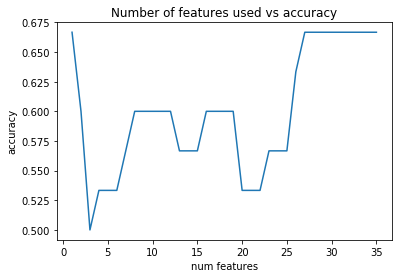

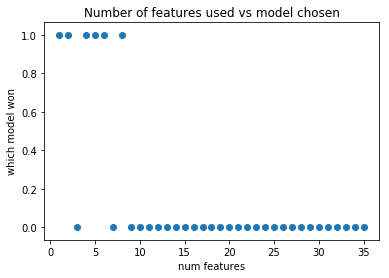

In [17]:
plt.plot(list(range(1,num_feats)), accs)
plt.xlabel("num features")
plt.ylabel("accuracy")
plt.title("Number of features used vs accuracy")
plt.show()

plt.scatter(list(range(1,num_feats)), indxs)
plt.xlabel("num features")
plt.ylabel("which model won")
plt.title("Number of features used vs model chosen")
plt.show()

## Brain decode
epochs, batch size


In [18]:
from braindecode.datautil.signal_target import SignalAndTarget
from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from braindecode.torch_ext.util import set_random_seeds

from braindecode.torch_ext.optimizers import AdamW
import time
import torch.nn.functional as F


# Split data up
percent_train = 0.7
num_train = int(len(X) * percent_train)
percent_valid = 0.1
num_valid = int(len(X) * percent_valid)

train_set = SignalAndTarget(X[:num_train], Y[:num_train]-1)
valid_set = SignalAndTarget(X[num_train:num_train + num_valid], Y[num_train:num_train + num_valid]-1)
test_set = SignalAndTarget(X[num_train + num_valid:], y=Y[num_train + num_valid:]-1)
whole_set = SignalAndTarget(X, Y-1)

In [19]:
train_set.y

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1])

In [20]:
# Brain Decode model

start_time = time.time()
cuda = False
set_random_seeds(seed=20170629, cuda=cuda)
n_classes = 2
in_chans = train_set.X.shape[1]
# final_conv_length = auto ensures we only get a single output in the time dimension
model_t = ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes,
                        input_time_length=train_set.X.shape[2], 
                        #filter_time_length=4,
                        final_conv_length='auto')
if cuda:
    model_t.cuda()
    
optimizer = AdamW(model_t.parameters(), lr=1*0.01, weight_decay=0.5*0.001) # these are good values for the deep model
#optimizer = AdamW(model_t.parameters(), lr=0.0625 * 0.01, weight_decay=0)
model_t.compile(loss=F.nll_loss, optimizer=optimizer, iterator_seed=1)

model_t.fit(train_set.X, train_set.y, epochs=100, batch_size=10, scheduler='cosine', validation_data=(valid_set.X, valid_set.y))

end_time = time.time()
elapsed = end_time - start_time
print("time taken:", elapsed, "s")

time taken: 20.113713026046753 s


In [21]:
pred_train_y = model_t.predict_classes(train_set.X)

sum(train_set.y == pred_train_y) / len(pred_train_y)

1.0

In [22]:
pred_valid_y = model_t.predict_classes(valid_set.X)

sum(valid_set.y == pred_valid_y) / len(pred_valid_y)

0.3333333333333333

In [23]:
pred_test_y = model_t.predict_classes(test_set.X)

sum(test_set.y == pred_test_y) / len(pred_test_y)

0.6666666666666666

In [24]:
pred_test_y

array([1, 0, 0, 1, 1, 0])

In [25]:
test_set.y

array([0, 0, 0, 1, 1, 1])

## XDawn

In [26]:
# # for models:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace


In [27]:
# XDawn
class XDawnLRModel(myModel): # XDAWN Covariance Preprocessing + Linear Regression Classifier
    def __init__(self):
        super().__init__()
        self.XC = XdawnCovariances(nfilter = 1) # the number of filters can be changed
        self.logreg = LogisticRegression()
        
    def fit(self, X, Y):
        X_transformed = self.XC.fit_transform(X, Y)
        X_transformed = TangentSpace(metric='riemann').fit_transform(X_transformed)
        self.logreg.fit(X_transformed,Y)
        
    def predict(self, X):
        X_transformed = self.XC.transform(X)
        X_transformed = TangentSpace(metric='riemann').fit_transform(X_transformed)
        return self.logreg.predict(X_transformed)
    
    def evaluate(self, X, Y): 
        loo = LeaveOneOut()
        X_transformed = self.XC.fit_transform(X, Y)
        X_transformed = TangentSpace(metric='riemann').fit_transform(X_transformed)
        y_pred = []
        y_true = []
        for train_ix, test_ix in loo.split(Y):
            # split data
            X_train, X_test = X_transformed[train_ix, :], X_transformed[test_ix, :]
            y_train, y_test = Y[train_ix], Y[test_ix]
            
            # fit model
            model = LogisticRegression()
            model.fit(X_train, y_train)
            
            # evaluate model
            yhat = model.predict(X_test)
            # store
            y_true.append(y_test[0])
            y_pred.append(yhat[0])
        
        # calculate accuracy
        acc = accuracy_score(y_true, y_pred)
        print('Accuracy: %.3f' % acc)



In [28]:
model = XDawnLRModel()
model.evaluate(X, Y)

Accuracy: 0.800


In [29]:
model = XDawnLRModel()
model.fit(X_train, Y_train)
# return model
Y_pred = model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           1       0.50      0.40      0.44         5
           2       0.40      0.50      0.44         4

    accuracy                           0.44         9
   macro avg       0.45      0.45      0.44         9
weighted avg       0.46      0.44      0.44         9



In [30]:
sum(Y_test == Y_pred)/len(Y_test)

0.4444444444444444

In [31]:
Y_test

array([1, 2, 1, 1, 1, 1, 2, 2, 2])

In [32]:
Y_pred

array([1, 2, 1, 2, 2, 2, 1, 2, 1])